<a href="https://colab.research.google.com/github/dyna478/Paz/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("devondev/financial-anomaly-data")

print("Path to dataset files:", path)

100%|██████████| 2.92M/2.92M [00:00<00:00, 49.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devondev/financial-anomaly-data/versions/1


#DATA Preprocessing

In [ ]:
df = pd.read_csv('/content/financial_anomaly_data.csv')

# Display the first few rows
print(df.head())

          Timestamp TransactionID AccountID    Amount   Merchant  \
0  01-01-2023 08:00       TXN1127      ACC4  95071.92  MerchantH   
1  01-01-2023 08:01       TXN1639     ACC10  15607.89  MerchantH   
2  01-01-2023 08:02        TXN872      ACC8  65092.34  MerchantE   
3  01-01-2023 08:03       TXN1438      ACC6     87.87  MerchantE   
4  01-01-2023 08:04       TXN1338      ACC6    716.56  MerchantI   

  TransactionType     Location  
0        Purchase        Tokyo  
1        Purchase       London  
2      Withdrawal       London  
3        Purchase       London  
4        Purchase  Los Angeles  


In [ ]:
unique_transaction_types = df['TransactionType'].unique()
print(unique_transaction_types)

['Purchase' 'Withdrawal' 'Transfer' nan]


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (if necessary)
df = df.dropna()

# Alternatively, fill missing values (e.g., for numerical columns)
df['Amount'].fillna(df['Amount'].median(), inplace=True)

In [ ]:
# Convert Timestamp to datetime with the correct format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Timestamp'].dt.month

In [ ]:
import numpy as np

# Apply log transformation to Amount
df['Amount_log'] = np.log(df['Amount'] + 1)
df['Amount_abs'] = df['Amount'].abs()
df = pd.get_dummies(df, columns=['TransactionType', 'Merchant', 'Location'], drop_first=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical columns
df[['Amount_log', 'Hour', 'DayOfWeek']] = scaler.fit_transform(df[['Amount_log', 'Hour', 'DayOfWeek']])


In [ ]:
df_aggregated = df.groupby(['AccountID', pd.Grouper(key='Timestamp', freq='D')]).agg({
    'Amount': 'sum',
    'TransactionID': 'count'
}).reset_index()

# Rename columns
df_aggregated.rename(columns={'Amount': 'Total_Amount', 'TransactionID': 'Transaction_Count'}, inplace=True)


In [ ]:
df.to_csv('preprocessed_transactions.csv', index=False)


#Data Anntation

In [ ]:
df1 = pd.read_csv('/content/preprocessed_transactions.csv')

In [ ]:
# Step 1: Calculate quartiles and IQR
Q1 = df1['Amount'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df1['Amount'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Step 2: Define upper and lower thresholds
upper_threshold = Q3 + 3 * IQR
lower_threshold = Q1 - 3 * IQR

# Step 3: Label anomalies
df1['Anomaly'] = np.where(
    (df1['Amount'] > upper_threshold) | (df1['Amount'] < lower_threshold),
    1,  # Anomaly
    0   # Nominal (not an anomaly)
)

# Display the number of anomalies detected
num_anomalies = df1['Anomaly'].sum()
print(f"Number of anomalies detected: {num_anomalies}")

# Display the first few rows with anomaly labels
print(df1.head(20))

In [ ]:
anomaly_rows = df1[df1['Anomaly'] == 1]

# Display the anomaly rows
print(anomaly_rows)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller



# Convert Timestamp to datetime (if not already done)
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])

# Sort by Timestamp (ensure the data is in chronological order)
df1= df1.sort_values('Timestamp')

# Aggregate data by day (if needed)
df_daily = df1.groupby(pd.Grouper(key='Timestamp', freq='D')).agg({'Amount': 'sum'}).reset_index()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Timestamp'], df_daily['Amount'])
plt.title('Daily Transaction Amount Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.show()

# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_daily['Amount'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df_daily['Amount'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

# Perform Augmented Dickey-Fuller (ADF) test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Run ADF test on the daily transaction amounts
adf_test(df_daily['Amount'])

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller



# Convert Timestamp to datetime (if not already done)
df1['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by Timestamp (ensure the data is in chronological order)
df1 = df1.sort_values('Timestamp')

# Aggregate data by day (if needed)
df_daily = df1.groupby(pd.Grouper(key='Timestamp', freq='D')).agg({'Amount': 'sum'}).reset_index()

# Perform Augmented Dickey-Fuller (ADF) test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Run ADF test on the daily transaction amounts
adf_test(df_daily['Amount'])

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
from pmdarima import auto_arima



# Convert Timestamp to datetime
df1['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by Timestamp
df1 = df.sort_values('Timestamp')

# Aggregate data by day
df_daily = df1.groupby(pd.Grouper(key='Timestamp', freq='D')).agg({'Amount': 'sum'}).reset_index()

# Stepwise search for best ARIMA parameters
model = auto_arima(
    df_daily['Amount'],  # Time series data
    start_p=0,           # Minimum value of p
    start_q=0,           # Minimum value of q
    max_p=5,             # Maximum value of p
    max_q=5,             # Maximum value of q
    d=None,              # Let the algorithm determine the best 'd'
    seasonal=False,       # Non-seasonal ARIMA
    trace=True,           # Print progress
    error_action='ignore', # Ignore invalid combinations
    suppress_warnings=True,
    stepwise=True         # Use stepwise algorithm for faster computation
)

# Print the best model parameters
print(model.summary())

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with optimal parameters (p, d, q)
model = ARIMA(df_daily['Amount'], order=(1, 0, 3))  # Replace (1, 0, 1) with your optimal parameters
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=0, end=len(df_daily) - 1)

In [ ]:
errors = predictions - df_daily['Amount']

In [ ]:
import numpy as np

# Mean of prediction errors
mu = np.mean(errors)

# Standard deviation of prediction errors
sigma = np.std(errors)

In [ ]:
threshold_upper = mu + 3 * sigma
threshold_lower = mu - 3 * sigma

In [ ]:
# Flag anomalies
df_daily['Anomaly'] = np.where(
    (errors > threshold_upper) | (errors < threshold_lower),
    1,  # Anomaly
    0   # Nominal
)

# Display anomalies
anomalies = df_daily[df_daily['Anomaly'] == 1]
print("Anomalies detected:")
print(anomalies)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with optimal parameters (p, d, q)
model = ARIMA(df_daily['Amount'], order=(1, 0, 3))  # Replace (1, 0, 1) with your optimal parameters
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=0, end=len(df_daily) - 1)

In [ ]:
# Calculate prediction errors
errors = predictions - df_daily['Amount']

In [ ]:
window_size = 9  # Window size for dynamic threshold

In [ ]:
import pandas as pd

# Calculate rolling mean and standard deviation
rolling_mean = errors.rolling(window=window_size, min_periods=1).mean()
rolling_std = errors.rolling(window=window_size, min_periods=1).std()

In [ ]:
# Upper and lower thresholds
threshold_upper = rolling_mean + 2 * rolling_std
threshold_lower = rolling_mean - 2 * rolling_std

In [ ]:
# Flag anomalies
df_daily['Anomaly'] = np.where(
    (errors > threshold_upper) | (errors < threshold_lower),
    1,  # Anomaly
    0   # Nominal
)

# Display anomalies
anomalies = df_daily[df_daily['Anomaly'] == 1]
print("Anomalies detected:")
print(anomalies)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(df_daily['Amount'], order=(1, 0, 1))  # Replace with your optimal parameters
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=0, end=len(df_daily) - 1)

# Calculate prediction errors
errors = predictions - df_daily['Amount']

# Flag anomalies using a threshold (e.g., 3σ)
threshold = 3 * errors.std()
df_daily['Predicted_Anomaly'] = (errors.abs() > threshold).astype(int)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# True labels (assume 'Anomaly' column exists in df_daily)
y_true = df_daily['Anomaly']  # Replace with your true labels
y_pred = df_daily['Predicted_Anomaly']

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f_score = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assume y_probs are the predicted probabilities for anomalies
y_probs = model_fit.predict(start=0, end=len(df_daily) - 1, typ='levels')  # Replace with your probability predictions

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Store metrics for each fold
precision_scores, recall_scores, f1_scores = [], [], []


for train_index, test_index in tscv.split(df_daily):
    train, test = df_daily.iloc[train_index], df_daily.iloc[test_index]
    model = ARIMA(train['Amount'], order=(1, 0, 3))
    model_fit = model.fit()
    predictions = model_fit.predict(start=test.index[0], end=test.index[-1])
    errors = predictions - test['Amount']
    threshold = 3 * errors.std()
    test['Predicted_Anomaly'] = (errors.abs() > threshold).astype(int)
    precision = precision_score(test['Anomaly'], test['Predicted_Anomaly'])
    recall = recall_score(test['Anomaly'], test['Predicted_Anomaly'])
    f1 = f1_score(test['Anomaly'], test['Predicted_Anomaly'])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Print average metrics
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

#Fixing the issues


In [ ]:
# Check the distribution of true labels
print("True Labels Distribution:")
print(df_daily['Anomaly'].value_counts())

In [ ]:
# Check the distribution of predicted labels
print("Predicted Labels Distribution:")
print(df_daily['Predicted_Anomaly'].value_counts())

In [ ]:
# Check for NaN values in Predicted_Anomaly
print("Number of NaN values in Predicted_Anomaly:", df_daily['Predicted_Anomaly'].isna().sum())

In [ ]:
# Option 1: Fill NaN values with 0 (no anomaly)
df_daily['Predicted_Anomaly'] = df_daily['Predicted_Anomaly'].fillna(0).astype(int)

# Option 2: Drop rows with NaN values (if appropriate)
df_daily = df_daily.dropna(subset=['Predicted_Anomaly'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
d = 0
# Check the length of errors and df_daily
print("Length of errors:", len(errors))
print("Length of df_daily:", len(df_daily))

# Recalculate predictions and errors
predictions = model_fit.predict(start=0, end=len(df_daily) - 1)
errors = predictions - df_daily['Amount']

# Handle differencing (if applicable)
if d > 0:  # d is the differencing order
    predictions = np.concatenate([[np.nan] * d, predictions])  # Add NaN for the first 'd' values
    errors = np.concatenate([[np.nan] * d, errors])

# Calculate threshold and flag anomalies
threshold = 2 * errors.std()
df_daily['Predicted_Anomaly'] = (np.abs(errors) > threshold).astype(int)

# Fill NaN values in Predicted_Anomaly (if any)
df_daily['Predicted_Anomaly'] = df_daily['Predicted_Anomaly'].fillna(0).astype(int)

# Recalculate metrics
precision = precision_score(y_true, df_daily['Predicted_Anomaly'])
recall = recall_score(y_true, df_daily['Predicted_Anomaly'])
f_score = f1_score(y_true, df_daily['Predicted_Anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")

In [ ]:
# Check for NaN or infinite values in errors
print("Number of NaN values in errors:", np.isnan(errors).sum())
print("Number of infinite values in errors:", np.isinf(errors).sum())

# Handle NaN or infinite values in errors (if any)
errors = np.nan_to_num(errors, nan=0.0, posinf=0.0, neginf=0.0)

# Recalculate threshold and Predicted_Anomaly
threshold = 2 * errors.std()
df_daily['Predicted_Anomaly'] = (np.abs(errors) > threshold).astype(int)

In [ ]:
# Adjust the threshold (e.g., 2σ instead of 3σ)
threshold = 2 * errors.std()
df_daily['Predicted_Anomaly'] = (np.abs(errors) > threshold).astype(int)

# Recalculate metrics
precision = precision_score(y_true, df_daily['Predicted_Anomaly'])
recall = recall_score(y_true, df_daily['Predicted_Anomaly'])
f_score = f1_score(y_true, df_daily['Predicted_Anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Timestamp'], df_daily['Amount'], label='Actual')
plt.plot(df_daily['Timestamp'], predictions, label='Predicted')
plt.scatter(df_daily[df_daily['Predicted_Anomaly'] == 1]['Timestamp'],
            df_daily[df_daily['Predicted_Anomaly'] == 1]['Amount'],
            color='red', label='Predicted Anomalies')
plt.legend()
plt.title('Actual vs Predicted Values with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train, test = train_test_split(df_daily, test_size=0.2, shuffle=False)

# Fit ARIMA model on training data
model = ARIMA(train['Amount'], order=(1, 0, 3))  # Replace with your optimal parameters
model_fit = model.fit()

# Generate predictions for the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Calculate prediction errors
errors = predictions - test['Amount']

# Flag anomalies
threshold = 2 * errors.std()
test['Predicted_Anomaly'] = (errors.abs() > threshold).astype(int)

# Recalculate metrics
precision = precision_score(test['Anomaly'], test['Predicted_Anomaly'])
recall = recall_score(test['Anomaly'], test['Predicted_Anomaly'])
f_score = f1_score(test['Anomaly'], test['Predicted_Anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")

In [ ]:
# Check the distribution of true labels
print("True Labels Distribution:")
print(df_daily['Anomaly'].value_counts())
# Check the distribution of predicted labels
print("Predicted Labels Distribution:")
print(df_daily['Predicted_Anomaly'].value_counts())
# Adjust the threshold (e.g., 2σ instead of 3σ)
threshold = 2 * errors.std()
df_daily['Predicted_Anomaly'] = (np.abs(errors) > threshold).astype(int)

# Recalculate metrics
precision = precision_score(y_true, df_daily['Predicted_Anomaly'])
recall = recall_score(y_true, df_daily['Predicted_Anomaly'])
f_score = f1_score(y_true, df_daily['Predicted_Anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Timestamp'], df_daily['Amount'], label='Actual')
plt.plot(df_daily['Timestamp'], predictions, label='Predicted')
plt.scatter(df_daily[df_daily['Predicted_Anomaly'] == 1]['Timestamp'],
            df_daily[df_daily['Predicted_Anomaly'] == 1]['Amount'],
            color='red', label='Predicted Anomalies')
plt.legend()
plt.title('Actual vs Predicted Values with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.show()
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train, test = train_test_split(df_daily, test_size=0.2, shuffle=False)

# Fit ARIMA model on training data
model = ARIMA(train['Amount'], order=(1, 0, 1))  # Replace with your optimal parameters
model_fit = model.fit()

# Generate predictions for the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Calculate prediction errors
errors = predictions - test['Amount']

# Flag anomalies
threshold = 2 * errors.std()
test['Predicted_Anomaly'] = (np.abs(errors) > threshold).astype(int)

# Recalculate metrics
precision = precision_score(test['Anomaly'], test['Predicted_Anomaly'])
recall = recall_score(test['Anomaly'], test['Predicted_Anomaly'])
f_score = f1_score(test['Anomaly'], test['Predicted_Anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")

#AR Model

In [ ]:
unique_location_types = df['Location'].unique()
print(unique_location_types)

['Tokyo' 'London' 'Los Angeles' 'San Francisco' 'New York' nan]


In [ ]:
df2

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles
...,...,...,...,...,...,...,...
217436,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown
217437,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown
217438,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown
217439,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown


In [ ]:
df2 = pd.read_csv('/content/financial_anomaly_data.csv')
df2['TransactionType'] = df2['TransactionType'].fillna('Unknown')
df2['Location'] = df2['Location'].fillna('Unknown')


In [ ]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df2, columns=['TransactionType'], prefix='TransactionType')
df_encoded = pd.get_dummies(df2, columns=['Location', 'TransactionType'], prefix=['Location', 'TransactionType'])



print(df_encoded.head())

          Timestamp TransactionID AccountID    Amount   Merchant  \
0  01-01-2023 08:00       TXN1127      ACC4  95071.92  MerchantH   
1  01-01-2023 08:01       TXN1639     ACC10  15607.89  MerchantH   
2  01-01-2023 08:02        TXN872      ACC8  65092.34  MerchantE   
3  01-01-2023 08:03       TXN1438      ACC6     87.87  MerchantE   
4  01-01-2023 08:04       TXN1338      ACC6    716.56  MerchantI   

   Location_London  Location_Los Angeles  Location_New York  \
0            False                 False              False   
1             True                 False              False   
2             True                 False              False   
3             True                 False              False   
4            False                  True              False   

   Location_San Francisco  Location_Tokyo  Location_Unknown  \
0                   False            True             False   
1                   False           False             False   
2                   Fal

In [ ]:
print(df_encoded.isnull().sum())


Timestamp                     481
TransactionID                 481
AccountID                     481
Amount                        481
Merchant                      481
Location_London                 0
Location_Los Angeles            0
Location_New York               0
Location_San Francisco          0
Location_Tokyo                  0
Location_Unknown                0
TransactionType_Purchase        0
TransactionType_Transfer        0
TransactionType_Unknown         0
TransactionType_Withdrawal      0
dtype: int64


In [ ]:
# Drop rows with missing values
data1 = df_encoded.dropna()
print(data1.isnull().sum())


Timestamp                     0
TransactionID                 0
AccountID                     0
Amount                        0
Merchant                      0
Location_London               0
Location_Los Angeles          0
Location_New York             0
Location_San Francisco        0
Location_Tokyo                0
Location_Unknown              0
TransactionType_Purchase      0
TransactionType_Transfer      0
TransactionType_Unknown       0
TransactionType_Withdrawal    0
dtype: int64


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Conv1DTranspose
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

# ==================================================
# Step 1: Generate Synthetic Time-Series Data
# ==================================================
def generate_time_series(num_samples, time_steps, num_features):
    """Generate synthetic time-series data."""
    data = np.random.randn(num_samples, time_steps, num_features).astype(np.float32)
    return data

# Parameters
num_samples = 10000  # Total samples
time_steps = 20      # Sequence length
num_features = 128   # Features per time step

# Generate data
data = data1

# Split into training and validation sets
train_data = data[:8000]
val_data = data[8000:]

# ==================================================
# Step 2: Data Generator
# ==================================================
class TimeSeriesGenerator(Sequence):
    """Custom data generator for time-series data."""
    def __init__(self, data, batch_size=300):
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        batch = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        return batch, batch  # Autoencoder input = output

# Create generators
batch_size = 300
train_generator = TimeSeriesGenerator(train_data, batch_size)
val_generator = TimeSeriesGenerator(val_data, batch_size)

# ==================================================
# Step 3: Build the Autoencoder Model
# ==================================================
def build_autoencoder(input_shape):
    """Build a convolutional autoencoder."""
    model = Sequential([
        # Encoder
        Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        Conv1D(16, kernel_size=3, activation='relu', padding='same'),

        # Decoder
        Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.2),
        Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same'),
        Conv1DTranspose(num_features, kernel_size=3, padding='same')  # Output layer (no activation)
    ])
    return model

# Build the model
input_shape = (time_steps, num_features)
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# ==================================================
# Step 4: Training Configuration
# ==================================================
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training parameters
epochs = 40
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Train the model
history = autoencoder.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping]
)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Test reconstruction on a sample
sample = val_data[:1]  # Take one sample
reconstructed = autoencoder.predict(sample)

# Plot original vs reconstructed
plt.figure(figsize=(10, 6))
plt.plot(sample[0, :, 0], label='Original')
plt.plot(reconstructed[0, :, 0], label='Reconstructed')
plt.title('Original vs Reconstructed Time-Series')
plt.xlabel('Time Steps')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 20, 32)              │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 20, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_15                  │ (None, 20, 16)              │             784 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_16                  │ (None, 20, 32)              │           1,568 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_17                  │ (None, 20, 128)             │          12,416 │
│ (Conv1DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,640 (111.88 KB)

 Trainable params: 28,640 (111.88 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence

# Step 1: Data Preparation
# Inspect your data
print(data1.head())
print(data1.isnull().sum())
print(data1.dtypes)

# Extract relevant columns
time_series_data = data1[['Amount', 'Location_London', 'Location_Los Angeles', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Unknown', 'TransactionType_Withdrawal']]

# Convert to numpy array
time_series_data = time_series_data.to_numpy()

# Reshape into (num_samples, time_steps, num_features)
time_steps = 20  # Define the sequence length
num_features = time_series_data.shape[1]  # Number of features
num_samples = len(time_series_data) // time_steps  # Number of samples

# Reshape the data
time_series_data = time_series_data[:num_samples * time_steps]  # Trim to fit
time_series_data = time_series_data.reshape((num_samples, time_steps, num_features))

print(f"Reshaped data shape: {time_series_data.shape}")

# Step 2: Data Generator
class TimeSeriesGenerator(Sequence):
    """Custom data generator for time-series data."""
    def __init__(self, data, batch_size=300):
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = batch_x  # Autoencoder input = output
        return batch_x, batch_y

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        np.random.shuffle(self.data)

# Split into training and validation sets
train_data = time_series_data[:8000]  # First 8000 samples for training
val_data = time_series_data[8000:]    # Remaining samples for validation

# Create generators
batch_size = 300
train_generator = TimeSeriesGenerator(train_data, batch_size)
val_generator = TimeSeriesGenerator(val_data, batch_size)

# Verify the generator
batch_x, batch_y = train_generator[0]
print(f"Batch shape (inputs): {batch_x.shape}")
print(f"Batch shape (targets): {batch_y.shape}")

          Timestamp TransactionID AccountID    Amount   Merchant  \
0  01-01-2023 08:00       TXN1127      ACC4  95071.92  MerchantH   
1  01-01-2023 08:01       TXN1639     ACC10  15607.89  MerchantH   
2  01-01-2023 08:02        TXN872      ACC8  65092.34  MerchantE   
3  01-01-2023 08:03       TXN1438      ACC6     87.87  MerchantE   
4  01-01-2023 08:04       TXN1338      ACC6    716.56  MerchantI   

   Location_London  Location_Los Angeles  Location_New York  \
0            False                 False              False   
1             True                 False              False   
2             True                 False              False   
3             True                 False              False   
4            False                  True              False   

   Location_San Francisco  Location_Tokyo  Location_Unknown  \
0                   False            True             False   
1                   False           False             False   
2                   Fal

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Step 3: Build the Autoencoder Model
def build_autoencoder(input_shape):
    """Build a convolutional autoencoder."""
    model = Sequential([
        # Encoder
        Conv1D(32, kernel_size=3, strides=1, padding='same', input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Conv1D(16, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        # Decoder
        Conv1DTranspose(16, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Conv1DTranspose(32, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        # Output Layer
        Conv1DTranspose(input_shape[-1], kernel_size=3, padding='same')  # Reconstruct input
    ])
    return model

# Define input shape
input_shape = (20, 10)  # (time_steps, num_features)

# Build the model
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()

# Step 4: Train the Model
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training parameters
epochs = 40
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Train the model
history = autoencoder.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping]
)

# Step 5: Evaluate the Model
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Test reconstruction on a sample
sample = val_data[:1]  # Take one sample
reconstructed = autoencoder.predict(sample)

# Plot original vs reconstructed
plt.figure(figsize=(10, 6))
plt.plot(sample[0, :, 0], label='Original')
plt.plot(reconstructed[0, :, 0], label='Reconstructed')
plt.title('Original vs Reconstructed Time-Series')
plt.xlabel('Time Steps')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 20, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 10, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_18                  │ (None, 20, 16)              │             784 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_19                  │ (None, 20, 32)              │           1,568 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_20                  │ (None, 20, 10)              │             970 │
│ (Conv1DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,250 (24.41 KB)

 Trainable params: 6,058 (23.66 KB)

 Non-trainable params: 192 (768.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Invalid dtype: object

Data types before conversion: Amount                        float64
Location_London                  bool
Location_Los Angeles             bool
Location_New York                bool
Location_San Francisco           bool
Location_Tokyo                   bool
TransactionType_Purchase         bool
TransactionType_Transfer         bool
TransactionType_Unknown          bool
TransactionType_Withdrawal       bool
dtype: object
Data shape before reshaping: (216960, 10)
Data min/max values: 0.0 978942.25
Data contains NaN: False
Data contains Inf: False
Reshaped data shape: (10848, 20, 10)
Training data shape: (8678, 20, 10)
Validation data shape: (2170, 20, 10)
Batch shape (inputs): (300, 20, 10)
Batch shape (targets): (300, 20, 10)
Data type of batch: float32
Model input shape: (20, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 20, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 20, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 20, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_21                  │ (None, 20, 16)              │             784 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 20, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_22                  │ (None, 20, 32)              │           1,568 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_23                  │ (None, 20, 10)              │             970 │
│ (Conv1DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,250 (24.41 KB)

 Trainable params: 6,058 (23.66 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 334129984.0000 - val_loss: 336803552.0000 - learning_rate: 0.0010
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 336568704.0000 - val_loss: 336707072.0000 - learning_rate: 0.0010
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 336208064.0000 - val_loss: 336625376.0000 - learning_rate: 0.0010
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 335162080.0000 - val_loss: 336552128.0000 - learning_rate: 0.0010
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 336502080.0000 - val_loss: 336483072.0000 - learning_rate: 0.0010
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 335456416.0000 - val_loss: 336452512.0000 - learning_rate: 0.0010
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 334671264.0000 - val_loss: 336399488.0000 - learning_rate: 0.0010
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 334947552.0000 - val_loss: 336363328.0000 - learning_rate: 0.0010
Epoch 9/40


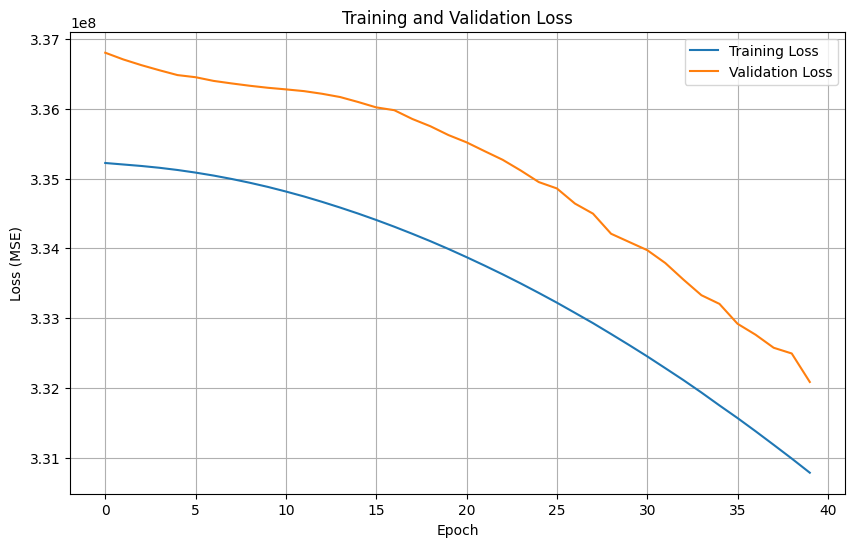

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


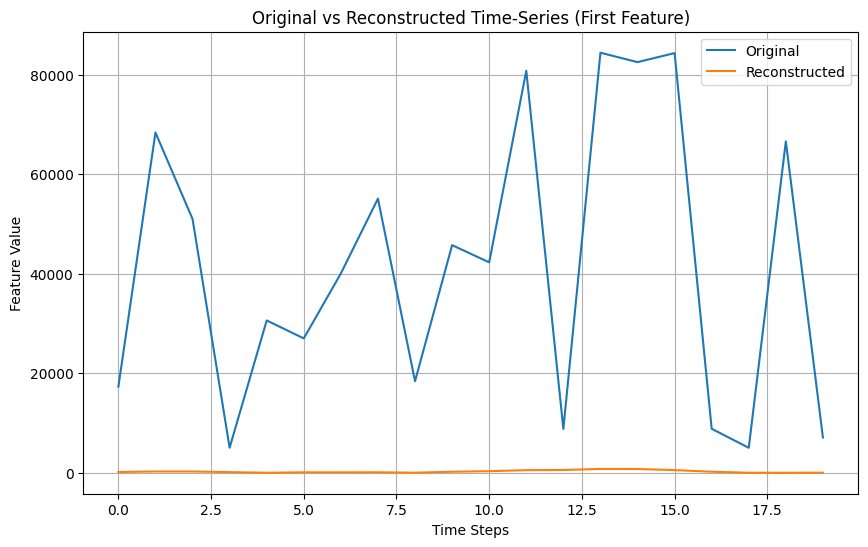

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Number of anomalies detected: 2
Percentage of anomalies: 0.09%
Anomaly threshold: 603781424.000000


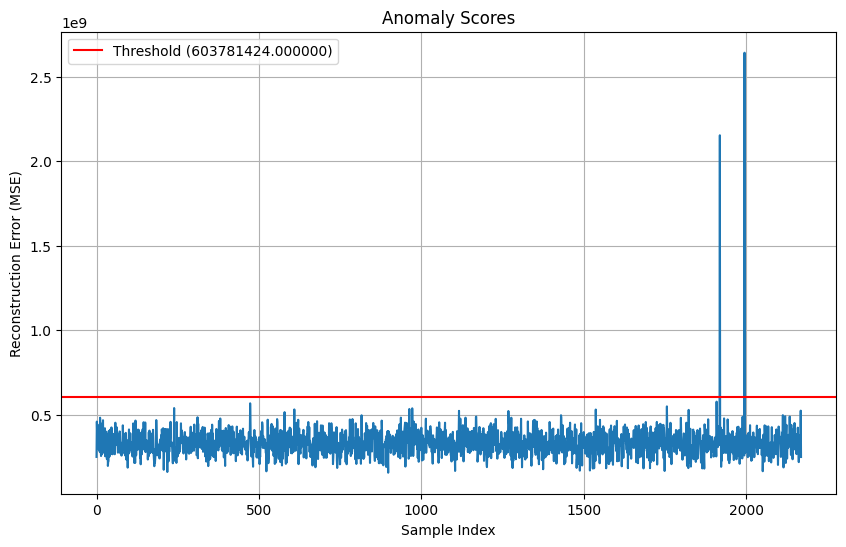

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Data Preparation
# Extract relevant columns - make sure all columns are numeric
time_series_data = data1[['Amount', 'Location_London', 'Location_Los Angeles',
                          'Location_New York', 'Location_San Francisco', 'Location_Tokyo',
                          'TransactionType_Purchase', 'TransactionType_Transfer',
                          'TransactionType_Unknown', 'TransactionType_Withdrawal']]

# Check data types and handle any non-numeric values
print("Data types before conversion:", time_series_data.dtypes)

# Convert all columns to float32
time_series_data = time_series_data.astype('float32')

# Check for NaN values and replace them
if time_series_data.isnull().sum().sum() > 0:
    print("Found NaN values. Replacing with zeros.")
    time_series_data = time_series_data.fillna(0)

# Convert to numpy array
time_series_data = time_series_data.to_numpy()

# Print some stats to verify data
print("Data shape before reshaping:", time_series_data.shape)
print("Data min/max values:", np.min(time_series_data), np.max(time_series_data))
print("Data contains NaN:", np.isnan(time_series_data).any())
print("Data contains Inf:", np.isinf(time_series_data).any())

# Reshape into (num_samples, time_steps, num_features)
time_steps = 20  # Define the sequence length
num_features = time_series_data.shape[1]  # Number of features (should be 10)
num_samples = len(time_series_data) // time_steps  # Number of samples

# Reshape the data
time_series_data = time_series_data[:num_samples * time_steps]  # Trim to fit
time_series_data = time_series_data.reshape((num_samples, time_steps, num_features))
print(f"Reshaped data shape: {time_series_data.shape}")

# Step 2: Data Generator
class TimeSeriesGenerator(Sequence):
    """Custom data generator for time-series data."""
    def __init__(self, data, batch_size=300):
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = batch_x  # Autoencoder input = output
        return batch_x, batch_y

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        indices = np.arange(len(self.data))
        np.random.shuffle(indices)
        self.data = self.data[indices]

# Split into training and validation sets (80/20 split)
train_size = int(0.8 * num_samples)
train_data = time_series_data[:train_size]
val_data = time_series_data[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# Create generators
batch_size = min(300, len(train_data))  # Make sure batch size isn't larger than dataset
train_generator = TimeSeriesGenerator(train_data, batch_size)
val_generator = TimeSeriesGenerator(val_data, batch_size)

# Verify the generator - this is important to check for errors
try:
    batch_x, batch_y = train_generator[0]
    print(f"Batch shape (inputs): {batch_x.shape}")
    print(f"Batch shape (targets): {batch_y.shape}")
    print(f"Data type of batch: {batch_x.dtype}")
except Exception as e:
    print(f"Error in generator: {e}")

# Step 3: Build the Autoencoder Model
def build_autoencoder(input_shape):
    """Build a convolutional autoencoder."""
    model = Sequential([
        # Encoder
        Conv1D(32, kernel_size=3, strides=1, padding='same', input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Conv1D(16, kernel_size=3, strides=1, padding='same'),  # Changed strides=2 to strides=1
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        # Decoder
        Conv1DTranspose(16, kernel_size=3, strides=1, padding='same'),  # Changed strides=2 to strides=1
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Conv1DTranspose(32, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        # Output Layer
        Conv1DTranspose(input_shape[-1], kernel_size=3, padding='same')  # Reconstruct input
    ])
    return model

# Define input shape
input_shape = (time_steps, num_features)  # Use the actual values
print(f"Model input shape: {input_shape}")

# Build the model
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()

# Step 4: Train the Model
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training parameters
epochs = 40
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Train the model
history = autoencoder.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping]
)

# Step 5: Evaluate the Model
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Test reconstruction on a sample
sample = val_data[:1]  # Take one sample
reconstructed = autoencoder.predict(sample)

# Plot original vs reconstructed for the first feature
plt.figure(figsize=(10, 6))
plt.plot(sample[0, :, 0], label='Original')
plt.plot(reconstructed[0, :, 0], label='Reconstructed')
plt.title('Original vs Reconstructed Time-Series (First Feature)')
plt.xlabel('Time Steps')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.show()

# Function to detect anomalies
def detect_anomalies(model, data, threshold_multiplier=3.0):
    """
    Detect anomalies in the data using the autoencoder.

    Args:
        model: Trained autoencoder model
        data: Input data to check for anomalies
        threshold_multiplier: Multiplier for the standard deviation to set the threshold

    Returns:
        Anomaly scores and anomaly flags (True for anomalies)
    """
    # Predict the reconstructions
    reconstructions = model.predict(data)

    # Calculate MSE for each sample
    mse = np.mean(np.square(data - reconstructions), axis=(1, 2))

    # Set threshold as mean + threshold_multiplier * std
    threshold = np.mean(mse) + threshold_multiplier * np.std(mse)

    # Flag anomalies
    anomalies = mse > threshold

    return mse, anomalies, threshold

# Detect anomalies in validation data
anomaly_scores, anomalies, threshold = detect_anomalies(autoencoder, val_data)

print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of anomalies: {np.sum(anomalies) / len(anomalies) * 100:.2f}%")
print(f"Anomaly threshold: {threshold:.6f}")

# Plot anomaly scores
plt.figure(figsize=(10, 6))
plt.plot(anomaly_scores)
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold ({threshold:.6f})')
plt.title('Anomaly Scores')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import seaborn as sns

# ==========================================
# Step 1: Improved Data Preparation
# ==========================================
def prepare_data(data1):
    """
    Prepare data with proper normalization and preprocessing
    """
    # Extract relevant columns
    time_series_data = data1[['Amount', 'Location_London', 'Location_Los Angeles',
                             'Location_New York', 'Location_San Francisco', 'Location_Tokyo',
                             'TransactionType_Purchase', 'TransactionType_Transfer',
                             'TransactionType_Unknown', 'TransactionType_Withdrawal']]

    # Handle missing values
    time_series_data = time_series_data.fillna(0)

    # Create a copy of raw data for later reference
    raw_data = time_series_data.copy()

    # Normalize each feature separately using StandardScaler
    scaler = StandardScaler()
    time_series_data_scaled = scaler.fit_transform(time_series_data)

    # Convert to numpy array and ensure float32 type
    time_series_data_scaled = time_series_data_scaled.astype(np.float32)

    # Reshape into (num_samples, time_steps, num_features)
    time_steps = 20  # Define the sequence length
    num_features = time_series_data_scaled.shape[1]  # Number of features

    # Calculate how many complete sequences we can create
    num_samples = len(time_series_data_scaled) // time_steps

    # Trim data to fit complete sequences
    time_series_data_scaled = time_series_data_scaled[:num_samples * time_steps]

    # Reshape the data
    shaped_data = time_series_data_scaled.reshape((num_samples, time_steps, num_features))

    print(f"Data shape after reshaping: {shaped_data.shape}")

    return shaped_data, scaler, raw_data, time_steps, num_features

# ==========================================
# Step 2: Build an LSTM Autoencoder
# ==========================================
def build_lstm_autoencoder(input_shape, encoding_dim=8):
    """
    Build an LSTM-based autoencoder that should perform better on sequential data
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Encoder
    x = LSTM(64, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = LSTM(32, activation='relu', return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # Encoded representation
    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    x = Dense(32, activation='relu')(encoded)
    x = RepeatVector(input_shape[0])(x)

    x = LSTM(32, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = TimeDistributed(Dense(input_shape[1]))(x)

    # Create model
    autoencoder = Model(inputs=inputs, outputs=outputs)

    # Compile model with a lower learning rate
    optimizer = Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder

# ==========================================
# Step 3: Improved Training Function
# ==========================================
def train_model(autoencoder, train_data, val_data, epochs=100, batch_size=64):
    """
    Train the model with better callbacks and configurations
    """
    # Callbacks for improved training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=0)

    # Train the model
    history = autoencoder.fit(
        train_data, train_data,  # Autoencoder input = output
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_data, val_data),
        callbacks=[reduce_lr, early_stopping, checkpoint],
        shuffle=True,
        verbose=1
    )

    return history

# ==========================================
# Step 4: Enhanced Anomaly Detection
# ==========================================
def detect_anomalies(model, data, threshold_percentile=95):
    """
    Detect anomalies using reconstruction error with a percentile-based threshold
    """
    # Get reconstructions
    reconstructions = model.predict(data)

    # Calculate MSE for each sample, sequence position, and feature
    # Then average over sequence positions and features
    mse = np.mean(np.square(data - reconstructions), axis=(1, 2))

    # Set threshold as a percentile of the MSE distribution
    threshold = np.percentile(mse, threshold_percentile)

    # Flag anomalies
    anomalies = mse > threshold

    return mse, anomalies, threshold, reconstructions

# ==========================================
# Step 5: Visualization Functions
# ==========================================
def plot_training_history(history):
    """Plot the training and validation loss"""
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_reconstructions(original, reconstructed, sample_idx=0, feature_idx=0):
    """Plot original vs reconstructed data for a single sample"""
    plt.figure(figsize=(12, 6))
    plt.plot(original[sample_idx, :, feature_idx], 'b-', label='Original', linewidth=2)
    plt.plot(reconstructed[sample_idx, :, feature_idx], 'r-', label='Reconstructed', linewidth=2)
    plt.title(f'Original vs Reconstructed Time-Series (Sample {sample_idx}, Feature {feature_idx})')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Feature Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_anomaly_scores(mse, threshold, anomalies=None):
    """Plot the anomaly scores with threshold"""
    plt.figure(figsize=(14, 7))

    # Plot reconstruction error
    plt.plot(mse, 'b-', alpha=0.6, label='Reconstruction Error')

    # If anomalies are provided, highlight them
    if anomalies is not None:
        plt.scatter(np.where(anomalies)[0], mse[anomalies],
                    color='red', alpha=0.7, s=50, label='Anomalies')

    plt.axhline(y=threshold, color='r', linestyle='-',
               label=f'Threshold ({threshold:.4f})')

    plt.title('Anomaly Scores')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(original, reconstructed):
    """
    Calculate and plot which features contribute most to reconstruction error
    """
    # Calculate MSE per feature
    feature_mse = np.mean(np.square(original - reconstructed), axis=(0, 1))

    # Create feature names
    feature_names = ['Amount', 'London', 'Los Angeles', 'New York',
                     'San Francisco', 'Tokyo', 'Purchase', 'Transfer',
                     'Unknown', 'Withdrawal']

    # Sort by importance
    sorted_idx = np.argsort(feature_mse)[::-1]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_mse)), feature_mse[sorted_idx])
    plt.xticks(range(len(feature_mse)), [feature_names[i] for i in sorted_idx], rotation=45)
    plt.title('Feature Contribution to Reconstruction Error')
    plt.xlabel('Features')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()

# ==========================================
# Main Execution Function
# ==========================================
def run_fraud_detection(data1):
    """
    Run the complete fraud detection pipeline
    """
    # Step 1: Prepare data
    print("Preparing data...")
    shaped_data, scaler, raw_data, time_steps, num_features = prepare_data(data1)

    # Split into training and validation sets (80/20 split)
    train_size = int(0.8 * shaped_data.shape[0])
    train_data = shaped_data[:train_size]
    val_data = shaped_data[train_size:]

    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")

    # Step 2: Build model
    print("Building LSTM autoencoder model...")
    input_shape = (time_steps, num_features)
    autoencoder = build_lstm_autoencoder(input_shape)
    autoencoder.summary()

    # Step 3: Train model
    print("Training model...")
    history = train_model(autoencoder, train_data, val_data)

    # Step 4: Evaluate model
    print("Evaluating model...")
    # Plot training history
    plot_training_history(history)

    # Get reconstructions for validation data
    mse, anomalies, threshold, reconstructions = detect_anomalies(autoencoder, val_data)

    # Plot a sample reconstruction
    plot_reconstructions(val_data, reconstructions)

    # Plot anomaly scores
    plot_anomaly_scores(mse, threshold, anomalies)

    # Calculate and print statistics
    anomaly_percentage = np.mean(anomalies) * 100
    print(f"Number of anomalies detected: {np.sum(anomalies)} out of {len(anomalies)}")
    print(f"Percentage of anomalies: {anomaly_percentage:.2f}%")
    print(f"Anomaly threshold: {threshold:.6f}")

    # Plot feature importance
    plot_feature_importance(val_data, reconstructions)

    # Return key components for further analysis if needed
    return autoencoder, scaler, mse, anomalies, threshold

# Add a function to make predictions on new data
def predict_anomalies(model, scaler, new_data, threshold, time_steps=20):
    """
    Make predictions on new data

    Args:
        model: Trained autoencoder model
        scaler: Fitted scaler object
        new_data: New data to predict on (DataFrame)
        threshold: Anomaly threshold
        time_steps: Sequence length used in training

    Returns:
        DataFrame with original data and anomaly scores
    """
    # Scale new data
    scaled_data = scaler.transform(new_data)

    # Reshape if multiple samples
    num_samples = len(scaled_data) // time_steps
    if num_samples > 0:
        # Trim data to fit complete sequences
        scaled_data = scaled_data[:num_samples * time_steps]
        # Reshape
        shaped_data = scaled_data.reshape((num_samples, time_steps, scaled_data.shape[1]))

        # Get reconstructions
        reconstructions = model.predict(shaped_data)

        # Calculate reconstruction error
        mse = np.mean(np.square(shaped_data - reconstructions), axis=(1, 2))

        # Flag anomalies
        anomalies = mse > threshold

        # Create result DataFrame
        result = pd.DataFrame({
            'reconstruction_error': mse,
            'is_anomaly': anomalies
        })

        return result
    else:
        print("Not enough data points for a complete sequence")
        return None

# Example usage of the full pipeline (commented out)
# Run the pipeline
# autoencoder, scaler, mse, anomalies, threshold = run_fraud_detection(data1)

Preparing data...
Data shape after reshaping: (10848, 20, 10)
Training data shape: (8678, 20, 10)
Validation data shape: (2170, 20, 10)
Building LSTM autoencoder model...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 20, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 20, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 20, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 10)              │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,738 (260.70 KB)

 Trainable params: 66,354 (259.20 KB)

 Non-trainable params: 384 (1.50 KB)

Training model...
Epoch 1/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.6116

136/136 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - loss: 1.6074 - val_loss: 0.9030 - learning_rate: 0.0010
Epoch 2/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.0553

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 1.0549 - val_loss: 0.9006 - learning_rate: 0.0010
Epoch 3/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9621

136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.9619 - val_loss: 0.8969 - learning_rate: 0.0010
Epoch 4/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.9262

136/136 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.9261 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 5/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.9069

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.9069 - val_loss: 0.8897 - learning_rate: 0.0010
Epoch 6/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8958

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8957 - val_loss: 0.8873 - learning_rate: 0.0010
Epoch 7/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8913

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.8913 - val_loss: 0.8836 - learning_rate: 0.0010
Epoch 8/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8868

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.8868 - val_loss: 0.8812 - learning_rate: 0.0010
Epoch 9/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8842

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.8842 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 10/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8818

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.8818 - val_loss: 0.8777 - learning_rate: 0.0010
Epoch 11/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8802

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.8802 - val_loss: 0.8762 - learning_rate: 0.0010
Epoch 12/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8786

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.8786 - val_loss: 0.8750 - learning_rate: 0.0010
Epoch 13/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8773

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.8774 - val_loss: 0.8736 - learning_rate: 0.0010
Epoch 14/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8781

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8781 - val_loss: 0.8726 - learning_rate: 0.0010
Epoch 15/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8763

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.8763 - val_loss: 0.8720 - learning_rate: 0.0010
Epoch 16/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8765

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.8765 - val_loss: 0.8715 - learning_rate: 0.0010
Epoch 17/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8743

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.8743 - val_loss: 0.8710 - learning_rate: 0.0010
Epoch 18/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8751

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.8751 - val_loss: 0.8701 - learning_rate: 0.0010
Epoch 19/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.8737 - val_loss: 0.8702 - learning_rate: 0.0010
Epoch 20/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8723

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8724 - val_loss: 0.8691 - learning_rate: 0.0010
Epoch 21/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.8745

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8744 - val_loss: 0.8690 - learning_rate: 0.0010
Epoch 22/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8736

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8736 - val_loss: 0.8673 - learning_rate: 0.0010
Epoch 23/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8717

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.8717 - val_loss: 0.8654 - learning_rate: 0.0010
Epoch 24/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8697 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 25/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8693

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8693 - val_loss: 0.8627 - learning_rate: 0.0010
Epoch 26/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8680

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.8680 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 27/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8659

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.8659 - val_loss: 0.8594 - learning_rate: 0.0010
Epoch 28/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8654

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8654 - val_loss: 0.8576 - learning_rate: 0.0010
Epoch 29/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8633

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8633 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 30/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8609

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.8609 - val_loss: 0.8550 - learning_rate: 0.0010
Epoch 31/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8607

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8607 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 32/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8610

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8610 - val_loss: 0.8514 - learning_rate: 0.0010
Epoch 33/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.8586

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.8586 - val_loss: 0.8506 - learning_rate: 0.0010
Epoch 34/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8568

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8569 - val_loss: 0.8498 - learning_rate: 0.0010
Epoch 35/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.8576

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.8575 - val_loss: 0.8473 - learning_rate: 0.0010
Epoch 36/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8577 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 37/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.8561 - val_loss: 0.8483 - learning_rate: 0.0010
Epoch 38/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8541

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8541 - val_loss: 0.8458 - learning_rate: 0.0010
Epoch 39/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.8542 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 40/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8546 - val_loss: 0.8463 - learning_rate: 0.0010
Epoch 41/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8519

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8519 - val_loss: 0.8436 - learning_rate: 0.0010
Epoch 42/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8531 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 43/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8523 - val_loss: 0.8444 - learning_rate: 0.0010
Epoch 44/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8512

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8512 - val_loss: 0.8433 - learning_rate: 0.0010
Epoch 45/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8511

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.8511 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 46/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.8504

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.8504 - val_loss: 0.8421 - learning_rate: 0.0010
Epoch 47/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8496

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8496 - val_loss: 0.8403 - learning_rate: 0.0010
Epoch 48/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8507 - val_loss: 0.8436 - learning_rate: 0.0010
Epoch 49/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.8493 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 50/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8501

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.8501 - val_loss: 0.8396 - learning_rate: 0.0010
Epoch 51/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.8483 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 52/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.8499 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 53/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8580 - val_loss: 0.8420 - learning_rate: 0.0010
Epoch 54/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8552 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 55/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8504

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8504 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 56/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8473 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 57/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.8479 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 58/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8493

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.8493 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 59/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8470 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 60/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8473 - val_loss: 0.8373 - learning_rate: 0.0010
Epoch 61/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.8471 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 62/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.8472 - val_loss: 0.8456 - learning_rate: 0.0010
Epoch 63/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8477

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.8477 - val_loss: 0.8367 - learning_rate: 0.0010
Epoch 64/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.8468 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 65/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8460 - val_loss: 0.8373 - learning_rate: 0.0010
Epoch 66/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.8472

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.8472 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 67/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8454

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.8454 - val_loss: 0.8344 - learning_rate: 0.0010
Epoch 68/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8447 - val_loss: 0.8371 - learning_rate: 0.0010
Epoch 69/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8458 - val_loss: 0.8458 - learning_rate: 0.0010
Epoch 70/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.8447

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8447 - val_loss: 0.8337 - learning_rate: 0.0010
Epoch 71/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.8457 - val_loss: 0.8389 - learning_rate: 0.0010
Epoch 72/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.8461 - val_loss: 0.8354 - learning_rate: 0.0010
Epoch 73/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.8455

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.8455 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 74/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.8463 - val_loss: 0.8414 - learning_rate: 0.0010
Epoch 75/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.8452 - val_loss: 0.8373 - learning_rate: 0.0010
Epoch 76/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.8437 - val_loss: 0.8404 - learning_rate: 0.0010
Epoch 77/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8463 - val_loss: 0.8351 - learning_rate: 0.0010
Epoch 78/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8439
Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.8439 - val_loss: 0.8429 - learning_rate: 0.0010
Epoch 79/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8427

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.8427 - val_loss: 0.8304 - learning_rate: 5.0000e-04
Epoch 80/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8427

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.8427 - val_loss: 0.8299 - learning_rate: 5.0000e-04
Epoch 81/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8427

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8427 - val_loss: 0.8288 - learning_rate: 5.0000e-04
Epoch 82/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8437

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8437 - val_loss: 0.8283 - learning_rate: 5.0000e-04
Epoch 83/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8420 - val_loss: 0.8299 - learning_rate: 5.0000e-04
Epoch 84/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8413 - val_loss: 0.8307 - learning_rate: 5.0000e-04
Epoch 85/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.8404 - val_loss: 0.8305 - learning_rate: 5.0000e-04
Epoch 86/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.8423

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.8422 - val_loss: 0.8272 - learning_rate: 5.0000e-04
Epoch 87/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8409 - val_loss: 0.8274 - learning_rate: 5.0000e-04
Epoch 88/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8402

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8402 - val_loss: 0.8269 - learning_rate: 5.0000e-04
Epoch 89/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.8401

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.8401 - val_loss: 0.8249 - learning_rate: 5.0000e-04
Epoch 90/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.8428

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.8428 - val_loss: 0.8248 - learning_rate: 5.0000e-04
Epoch 91/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8385 - val_loss: 0.8289 - learning_rate: 5.0000e-04
Epoch 92/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8387 - val_loss: 0.8265 - learning_rate: 5.0000e-04
Epoch 93/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.8391 - val_loss: 0.8252 - learning_rate: 5.0000e-04
Epoch 94/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.8409
Epoch 94: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.8409 - val_loss: 0.8291 - learning_rate: 5.0000e-04
Epoch 95/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8386

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.8386 - val_loss: 0.8243 - learning_rate: 2.5000e-04
Epoch 96/100
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8403

136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.8402 - val_loss: 0.8233 - learning_rate: 2.5000e-04
Epoch 97/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8405

136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.8405 - val_loss: 0.8220 - learning_rate: 2.5000e-04
Epoch 98/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.8377 - val_loss: 0.8238 - learning_rate: 2.5000e-04
Epoch 99/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.8384 - val_loss: 0.8238 - learning_rate: 2.5000e-04
Epoch 100/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8382 - val_loss: 0.8224 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 97.
Evaluating model...


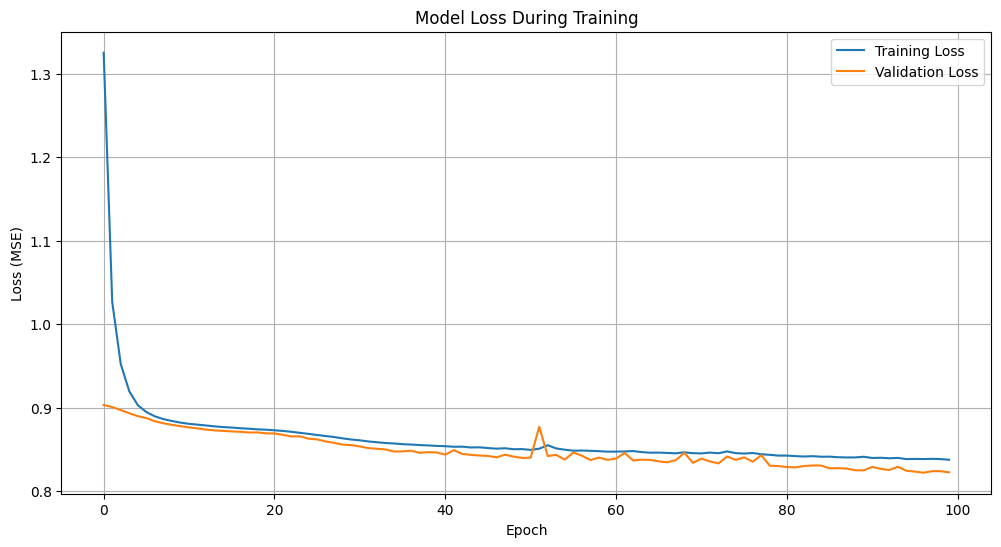

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


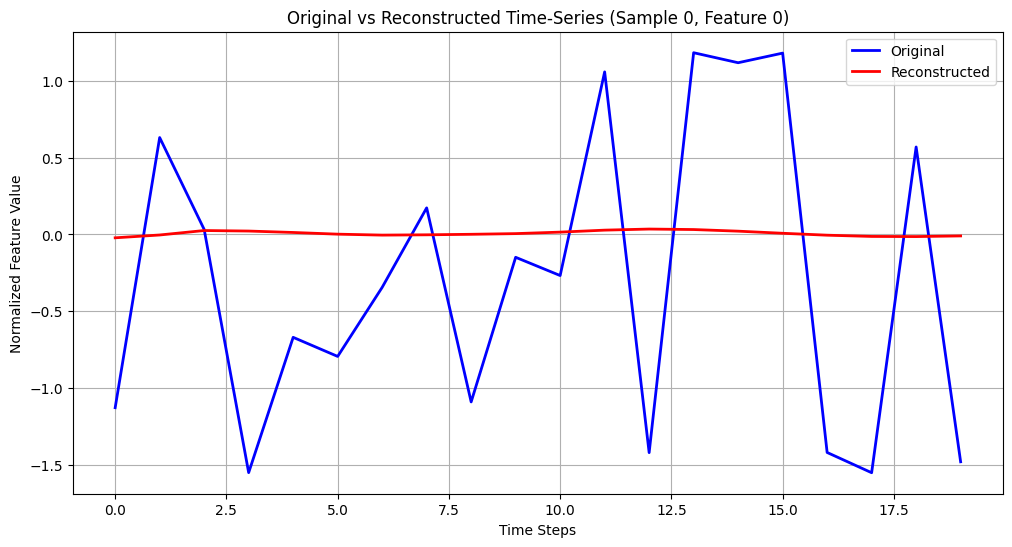

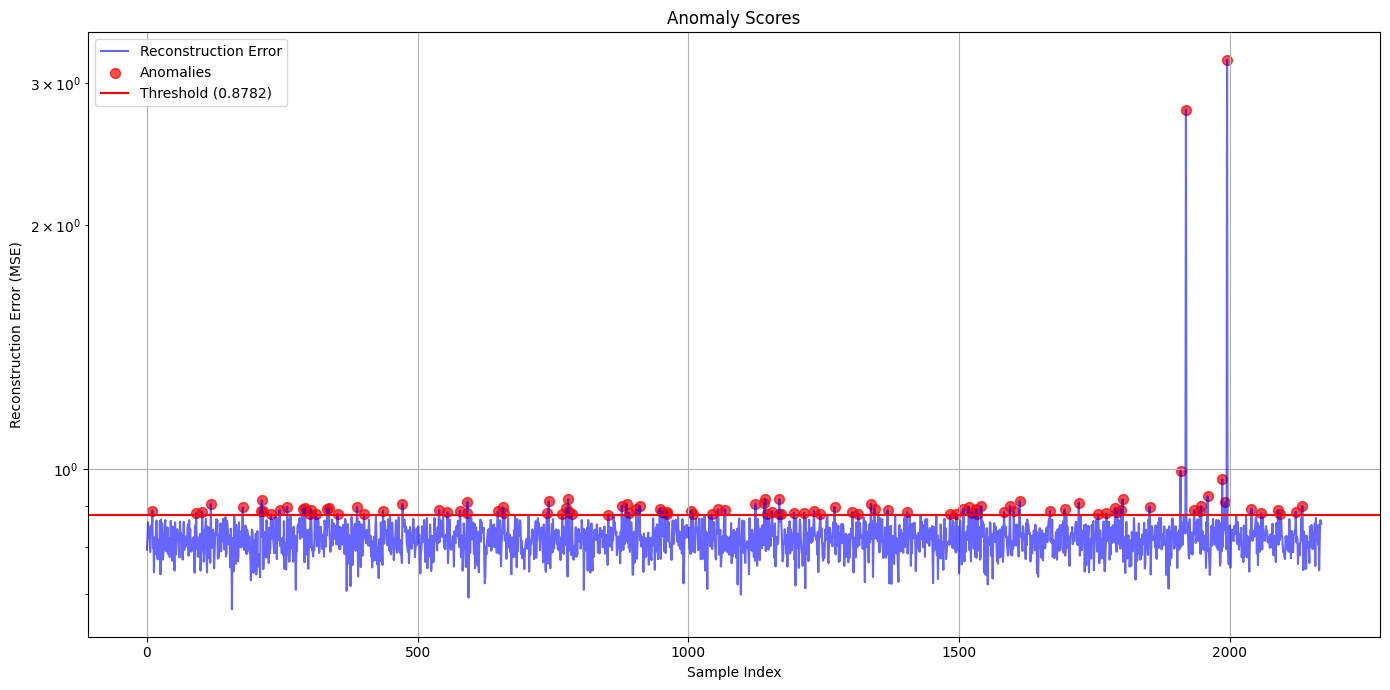

Number of anomalies detected: 109 out of 2170
Percentage of anomalies: 5.02%
Anomaly threshold: 0.878201


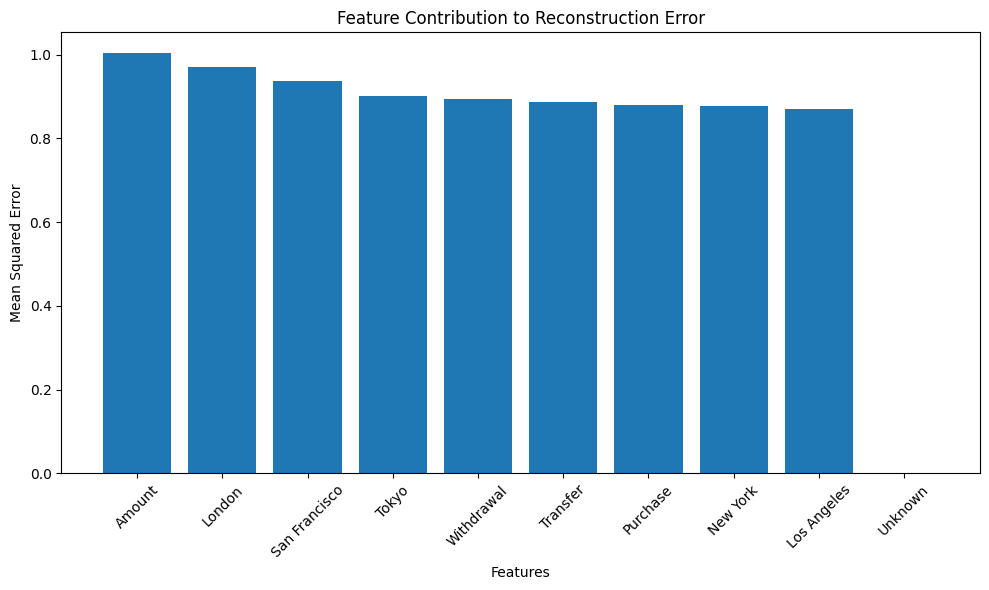

In [ ]:
autoencoder, scaler, mse, anomalies, threshold = run_fraud_detection(data1)